In [11]:
# 라이브러리 불러오기
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import asyncio
import json
import nest_asyncio
import pandas as pd
import re
from tqdm import tqdm
import time 

nest_asyncio.apply()

In [3]:
urls = pd.read_csv("../../data/KP_daum_monthlyTop800_body.csv")

In [4]:
urls

,Unnamed: 0,0,1,2
0,0,https://v.daum.net/v/20180105100954077,카카오페이 오프라인 확장..'카카오페이 카드' 10일 나온다,[카카오페이 카드 2종 온라인 간판결제 '카카오페이'가 '카카오페이 카드'를 출시하...
1,1,https://v.daum.net/v/20180105164004067,카카오페이 카드 출시,[카카오페이(대표 류영준)는 다양한 온·오프라인 혜택을 담은 혼합형 핀테크 상품 '...
2,2,https://v.daum.net/v/20180105101958491,"카카오페이, 체크카드 출시..오프라인 진출",[ 【서울=뉴시스】카카오페이는 다양한 온·오프라인 혜택을 담은 ...
3,3,https://v.daum.net/v/20180105173046721,오프라인 결제 '카카오페이 카드' 출시,[카카오페이 카드 2종 온라인 간판결제 '카카오페이'가 '카카...
4,4,https://v.daum.net/v/20180105084208085,'카카오페이 카드' 출시.. 다양한 혜택 제공,"[ 이용금액 0.3% 자동 적립, 롯데 ATM 무료 출금 가능카카오페이가 다양한 온..."
...,...,...,...,...
18382,18382,https://v.daum.net/v/20221230105630139,"파리바게뜨, 새해 1월 ‘파바데이’ 프로모션 진행",[ 1만5000원 이상 구매 시 3000원 혜택설 선물 연계 2만원 이상 구매시 5...
18383,18383,https://v.daum.net/v/20221230071650319,"용인시, 청년 전세보증금 반환보증 보증료 최대 30만원 지원",[ 용인청년 전세보증금 반환보증 보증료 지원사업 홍보 포스터 ...
18384,18384,https://v.daum.net/v/20221230052321943,2금융 대출문턱 막히자… 금융당국 유연하게 대응 당부,[ 2금융권을 중심으로 서민들의 자금조달이 어려워지자 금융당국이...
18385,18385,https://v.daum.net/v/20221228120203288,내년부터 '깜깜이' 간편결제 수수료 공시된다,"[ 금감원, 전자금융업자 수수료 공시 가이드라인 시행네이버페이, 카카오페이 10개사..."


In [5]:
test = urls.iloc[:, 1:2]

In [6]:
test[:1]

,0
0,https://v.daum.net/v/20180105100954077


In [10]:
test

,0
0,https://v.daum.net/v/20180105100954077
1,https://v.daum.net/v/20180105164004067
2,https://v.daum.net/v/20180105101958491
3,https://v.daum.net/v/20180105173046721
4,https://v.daum.net/v/20180105084208085
...,...
18382,https://v.daum.net/v/20221230105630139
18383,https://v.daum.net/v/20221230071650319
18384,https://v.daum.net/v/20221230052321943
18385,https://v.daum.net/v/20221228120203288


In [17]:
comment_list = []
for index, row in tqdm(test.iterrows(), total=len(test)):
    
    #기사 url 하나씨 꺼내서
    try:
        header = {
            'authority' : 'comment.daum.net',
            'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
            'accept' : "*/*",
            'accept-encoding' : 'gzip, deflate, br',
            'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
            'referer' : "",
        }
        #access_token_id 반환 (data-client-id)
        org = row['0']
        article_id = org.split("/")[-1]
        req = requests.get(org)
        soup = BeautifulSoup(req.content)
        data_client_id = soup.find('div',{'class':'alex-area'}).get('data-client-id')

        # authorization 값 반환, data-client-id를 주면 알 수 있음
        header['referer'] = org
        token_url = "https://alex.daum.net/oauth/token?grant_type=alex_credentials&client_id={}".format(data_client_id)
        req = requests.get(token_url, headers=header)
        access_token = json.loads(req.content)['access_token']
        authorization = 'Bearer '+access_token

        # article - comment 연결 짓는 key값 반환
        header['authorization'] = authorization
        post_url = """https://comment.daum.net/apis/v1/ui/single/main/@{}""".format(article_id)
        req = requests.get(post_url, headers = header)
        soup = BeautifulSoup(req.content,'html.parser')
        post_id = json.loads(soup.text)['post']['id']
        
        count = len(comment_list)
        # comment 조회
        offset = 0
    except:
        pass
    while True:
        try:
            request_url = """
            https://comment.daum.net/apis/v1/posts/{}/comments?parentId=0&offset={}&limit=100&sort=RECOMMEND&isInitial=false&hasNext=true
            """.format(post_id, offset)

            req = requests.get(request_url, headers=header)
            soup = BeautifulSoup(req.content,'html.parser')
            temp_json_list = json.loads(soup.text)
            for temp_json in temp_json_list:
                temp_json['org_url'] = org
            
            comment_list.extend(temp_json_list)
            if len(temp_json_list) < 100:
                break
            else:
                offset += 100
                time.sleep(1)
        except:
            pass
    
    #print(article_id, len(comment_list) - count)


100%|██████████| 18387/18387 [4:23:02<00:00,  1.17it/s]   


In [20]:
pd.DataFrame(comment_list).to_csv("../../data/KP_daum_comments_monthlyTop800.csv")
pd.DataFrame(comment_list).to_pickle("../../data/KP_daum_comments_monthlyTop800.pkl")

In [21]:
result = pd.DataFrame(comment_list)

In [25]:
result

,id,userId,postId,forumId,parentId,type,status,flags,rating,icon,content,createdAt,updatedAt,childCount,likeCount,dislikeCount,recommendCount,screenedByKeeper,user,org_url
0,203773412,3580467,27771481,-99,0,COMMENT,S,256,0,4411172:2:4,신청했는데ㅋ 조으다,2018-01-05T14:13:00+0900,2018-01-05T14:13:00+0900,0,0,0,0,False,"{'id': 3580467, 'status': 'S', 'icon': 'https:...",https://v.daum.net/v/20180105100954077
1,204026330,-556963703,27781199,-99,0,COMMENT,S,256,0,2200001:4:3,왜 롯데랑 붙었습니까...,2018-01-06T13:19:48+0900,2018-01-06T13:19:48+0900,0,0,0,0,False,"{'id': -556963703, 'status': 'S', 'icon': 'htt...",https://v.daum.net/v/20180105150001031
2,204203354,-30523365,27806152,-99,0,COMMENT,S,256,0,NaN,혜택 주는거 받아 먹으면 그걸로 이득인거니까 카드는 그런 혜택 받자고 쓰는거지 소비...,2018-01-07T10:00:56+0900,2018-01-07T10:00:56+0900,0,1,0,1,False,"{'id': -30523365, 'status': 'S', 'icon': 'http...",https://v.daum.net/v/20180107060036457
3,204592776,-8816213,27849284,-99,0,COMMENT,S,256,0,NaN,핸드폰간편결재 수수료가 신용카드 4배 정도다.\n한그릇 팔면 일은 내가 했는데 저...,2018-01-08T19:59:39+0900,2018-01-08T19:59:39+0900,3,48,5,43,False,"{'id': -8816213, 'status': 'S', 'icon': 'https...",https://v.daum.net/v/20180108194402485
4,204595953,-10275396,27849284,-99,0,COMMENT,S,256,0,NaN,차떼기당의 후예들도 전부 없어져라,2018-01-08T20:08:41+0900,2018-01-08T20:08:41+0900,0,20,1,19,False,"{'id': -10275396, 'status': 'D', 'icon': 'http...",https://v.daum.net/v/20180108194402485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71387,839646885,71407268,174443823,-99,0,COMMENT,S,0,0,4412206:3:4,네이버가 짱이지 ㅋㅋ\n\n올개 30만원 모임\n\n얌얌,2022-12-26T17:28:55+0900,2022-12-26T17:28:55+0900,0,0,0,0,False,"{'id': 71407268, 'status': 'S', 'icon': 'https...",https://v.daum.net/v/20221226050109898
71388,840302923,-98134365,174552834,-99,0,COMMENT,S,0,0,NaN,손절한 주식은???!!!,2022-12-29T21:04:43+0900,2022-12-29T21:04:43+0900,0,2,0,2,False,"{'id': -98134365, 'status': 'S', 'icon': 'http...",https://v.daum.net/v/20221229172340151
71389,840296870,-64074345,174552834,-99,0,COMMENT,S,0,0,NaN,배당금이나 주라,2022-12-29T20:22:02+0900,2022-12-29T20:22:02+0900,0,1,0,1,False,"{'id': -64074345, 'status': 'S', 'icon': 'http...",https://v.daum.net/v/20221229172340151
71390,840276196,4010993,174552834,-99,0,COMMENT,S,0,0,NaN,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,2022-12-29T18:06:32+0900,2022-12-29T18:06:32+0900,0,0,0,0,False,"{'id': 4010993, 'status': 'S', 'icon': 'https:...",https://v.daum.net/v/20221229172340151



Bad key "text.kerning_factor" on line 4 in
/home/mglee/anaconda3/envs/save/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


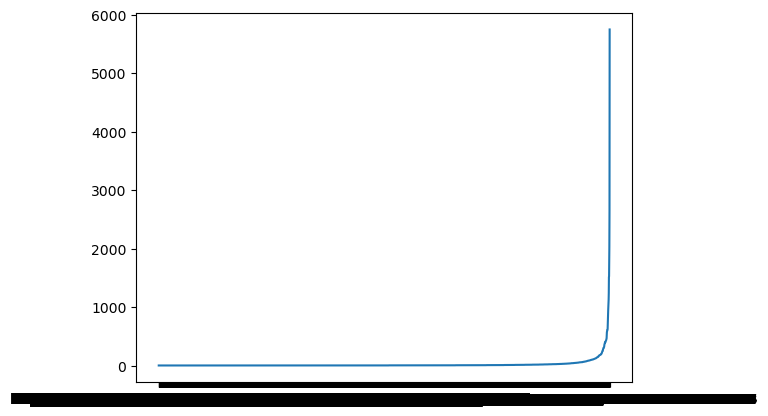

In [26]:
import matplotlib.pyplot as plt
plt.plot(result.groupby("org_url").size().sort_values())